In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize

## Variational Quantum State Preparation (VQSP)

In this notebook, I used a parameterized quantum circuit (PQC) to **prepare a target wavefield** arising from the 1D acoustic wave equation. The PQC is trained by adjusting its parameters \( \theta \) so that the output state

$$
\psi(\theta) = U(\theta)\,|0\cdots 0\rangle
$$

matches a desired target state \( |g\rangle \) (e.g., a normalized Ricker wavelet).

This process—**finding the optimal parameters \( \theta \)**—is known as **Variational Quantum State Preparation (VQSP)**. It is a standard NISQ-era method in which:

1. A cost function  
   $$
   C(\theta) = 1 - \mathrm{Re}\,\langle g \mid \psi(\theta) \rangle
   $$  
   measures alignment with the target state.

2. A classical optimizer (L-BFGS-B) updates \( \theta \) to minimize this cost.

3. The trained PQC provides a hardware-efficient representation of the target wavefield.

VQSP is a foundational component in quantum PDE simulation pipelines because it enables encoding of physically meaningful initial conditions directly into quantum states.


# Quantum Encoding step

the continuous wavelet function need to efficiently encoded into the amplitude distribution over the computational basis.

We want the initial quantum state
$$
|\Phi(0)\rangle = \sum_{j=0}^{N-1} \psi_j(0) |j\rangle
$$ 
to encode a spatial function $\psi(x, 0)$ — in this case, a Ricker wavelet. The Ricker wavelet is a localized oscillatory function often used to represent a pulse:
$$
\psi(x, 0) = \left(1 - \frac{x^2}{\sigma^2}\right)e^{-x^2/(2\sigma^2)}
$$ They discretize this over $N = 2^n$ grid points, map $x_j \rightarrow j$, and normalize it to unit norm to be a valid quantum state.


They can’t just “load” arbitrary amplitudes $\psi_j(0)$ directly — amplitude encoding is exponentially costly in general. So instead they use a shallow, trainable PQC (like a “quantum neural network”) to approximate that Ricker wavelet distribution.


# Parametrized Quantum Circuit (PQC)

Encoding it as a PQC state ensures:

* Exponential compression (amplitudes over $2^n$ basis states stored with $O(nL)$ parameters).
* Hardware feasibility (shallow depth → low noise).
* Differentiability (trainable circuit → variational preparation).


PQC Configuration Overview:

* Target state: Discretized Ricker wavelet $\psi(x, 0)$  
* Encoding: Amplitude encoding over computational basis  
* Circuit type: Shallow brickwall PQC (alternating Ry/CZ)  
* Depth: Small (few layers)  
* Parameters: Rotation angles $\boldsymbol{\theta}$  
* Training goal: Maximize fidelity with target wavelet  
* Output:  
  $|\Phi(0)\rangle = U(\boldsymbol{\theta}) |0\ldots0\rangle \approx |\psi_{\text{Ricker}}\rangle$  
* Purpose: Initialize quantum simulation efficiently


# The paper's PQC setup 
**(a) Brickwall layout**

* They use 7 qubits.  
* Circuit depth = 3 (three alternating layers of two-qubit blocks).  
* Total of 18 two-qubit blocks (each green rectangle).

Each two-qubit block has its own parameter set  
$$\boldsymbol{\theta}_m = (\theta_1^{(m)}, \ldots, \theta_9^{(m)})$$


**(b) Inside each two-qubit block**

Each block is a generic SU(4)-like entangling unit parameterized efficiently.

It’s structured as:

$$
U^{(m)} =
\left[ U_1(\theta_1^{(m)}, \theta_2^{(m)}, \theta_3^{(m)}) \otimes U_1(\theta_4^{(m)}, \theta_5^{(m)}, \theta_6^{(m)}) \right]
\cdot U_{\text{ent}}(\theta_7^{(m)}, \theta_8^{(m)}, \theta_9^{(m)})
\cdot \left[ U_1(\theta_{10}^{(m)}, \theta_{11}^{(m)}, \theta_{12}^{(m)}) \otimes U_1(\theta_{13}^{(m)}, \theta_{14}^{(m)}, \theta_{15}^{(m)}) \right]
$$

Where:

$$
U_1(\alpha, \beta, \gamma) = R_z(\alpha) R_y(\beta) R_z(\gamma)
$$

Entangling part uses:

$$
U_{\text{ent}} = \text{CNOT}_{1,2} \, R_z(\theta_7) \, R_y(\theta_8) \, \text{CNOT}_{2,1} \, R_y(\theta_9)
$$

That’s a universal two-qubit entangling gate parameterized by 9 angles.


Total parameters: 90


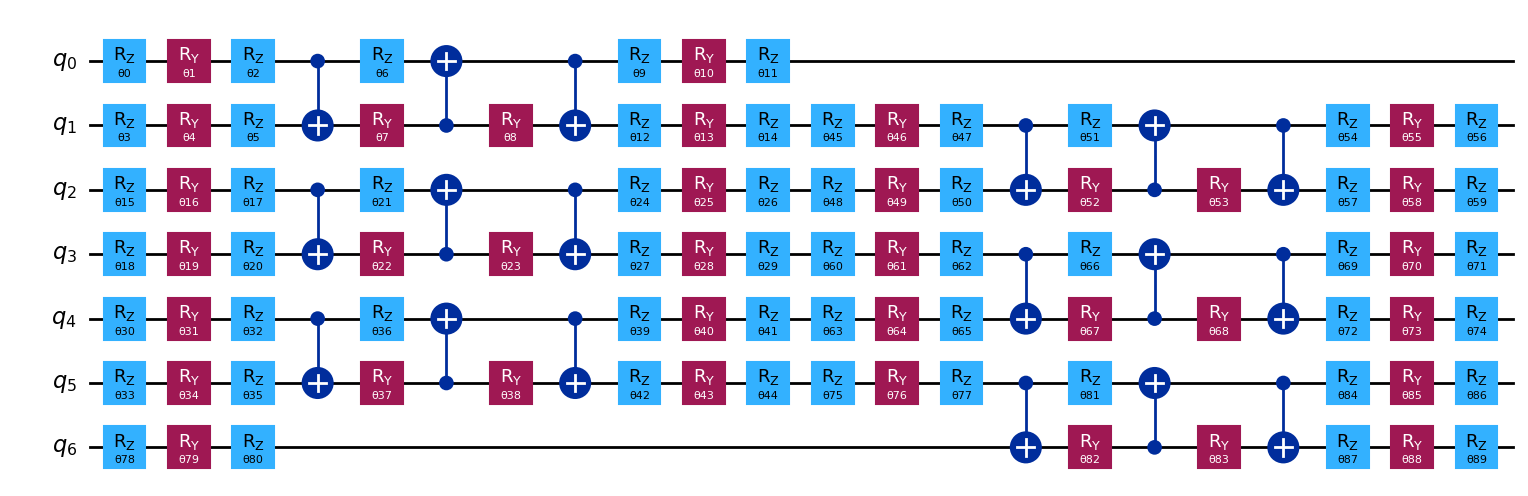

In [2]:
# ================================================================
#  Full Brickwall PQC (3-CNOT entangling blocks, Fig. 5 in paper)
# ================================================================


# --- 1. Generic single-qubit unitary U1(α,β,γ) = Rz(α) Ry(β) Rz(γ)
def U1(qc, q, a, b, c):
    qc.rz(a, q)
    qc.ry(b, q)
    qc.rz(c, q)

# --- 2. Three-CNOT entangling block (matches Fig. 5 b)
#     Sequence: CNOT(0→1) → Rz(q0) → Ry(q1) → CNOT(1→0) → Ry(q1) → CNOT(0→1)
def entangling_block(qc, q0, q1, thetas):
    # thetas = [θ7, θ8, θ9]
    qc.cx(q0, q1)          # first CNOT (q0→q1)
    qc.rz(thetas[0], q0)   # Rz on control
    qc.ry(thetas[1], q1)   # Ry on target
    qc.cx(q1, q0)          # second CNOT (q1→q0)
    qc.ry(thetas[2], q1)   # Ry on target again
    qc.cx(q0, q1)          # third CNOT (q0→q1)

# --- 3. Complete two-qubit block U^(m)
#     2× pre-rotations, 3-CNOT entangler, 2× post-rotations → 15 parameters total
def two_qubit_block(qc, q0, q1, thetas):
    """
    thetas = [θ1 ... θ15]
    """
    # Pre-rotations
    U1(qc, q0, thetas[0], thetas[1], thetas[2])
    U1(qc, q1, thetas[3], thetas[4], thetas[5])

    # Entangling section (3 CNOTs)
    entangling_block(qc, q0, q1, thetas[6:9])

    # Post-rotations
    U1(qc, q0, thetas[9], thetas[10], thetas[11])
    U1(qc, q1, thetas[12], thetas[13], thetas[14])

# --- 4. Assemble full brickwall PQC (Fig. 5 a)
def brickwall_PQC(n_qubits=4, depth=3):
    qc = QuantumCircuit(n_qubits)
    params = []
    param_index = 0

    for d in range(depth):
        # Alternate coupling pattern per layer: (0,1),(2,3) → (1,2) → repeat
        pairs = [(i, i + 1) for i in range(d % 2, n_qubits - 1, 2)]
        for (q0, q1) in pairs:
            thetas = [Parameter(f"θ{param_index + i}") for i in range(15)]
            params += thetas
            two_qubit_block(qc, q0, q1, thetas)
            param_index += 15
    return qc, params

# --- 5. Example usage
qc, params = brickwall_PQC(n_qubits=7, depth=2)
print(f"Total parameters: {len(params)}")
qc.draw('mpl')


# Brickwall PQC + Paper-Style Cost C(θ) + L-BFGS-B Training

 now moving to finding the thetas the makes this gates produce ricker wavelet like probabilities distribuation. This cost function is how the classical optimizer *teaches* the quantum circuit to reproduce the target wavefunction:

$$
\text{Train } U(\theta) \text{ so that } U(\theta)|0\rangle^{\otimes n} \approx |g\rangle 
\quad \text{by minimizing} \quad C(\theta) = 1 - \text{Re}\langle g|\psi(\theta)\rangle
$$


$$
C(\theta) = 1 - \text{Re} \left( \langle g(x) | U(\theta) | 0 \rangle^{\otimes n} \right)
$$


* $U(\theta)$: the parameterized quantum circuit (PQC) that prepares the quantum state.  
* $|0\rangle^{\otimes n}$: the initial “all-zeros” state on the quantum computer.  
* $|g(x)\rangle$: the target wavefunction (Ricker wavelet) represented as a complex vector.  
* $|\psi(\theta)\rangle = U(\theta)|0\rangle^{\otimes n}$: the state produced by the PQC for a given set of parameters.  
* $\langle g|\psi\rangle$: the complex inner product (overlap) — tells how close the two states are.  
* The cost function $C(\theta)$ is minimized when the real part of this overlap is maximized (i.e., when $|\psi\rangle$ matches $|g\rangle$).


* If the PQC perfectly matches the target ($\langle g|\psi\rangle = 1$),  
  → $C = 1 - 1 = 0$ → minimum cost.

* If the PQC produces an orthogonal state ($\langle g|\psi\rangle = 0$),  
  → $C = 1 - 0 = 1$ → maximum cost.



It’s the quantum analogue of minimizing mean-squared-error in neural networks — except here, instead of output neurons, you’re aligning complex amplitude vectors.



In [61]:
# ================================================================
#  Brickwall PQC + Paper-Style Cost C(θ) + L-BFGS-B Training
# ================================================================

# ---------- Target |g(x)⟩: Ricker wavelet over 2^n grid ----------
def ricker_target_state(n_qubits, sigma=0.8):
    N = 2 ** n_qubits
    # grid centered around 0 with unit spacing (rescale as you like)
    x = np.linspace(-(N-1)/2, (N-1)/2, N) / (N/4)
    g = (1 - (x**2)/(sigma**2)) * np.exp(-x**2/(2*sigma**2))  # real-valued Ricker
    g = g.astype(np.complex128)
    g /= np.linalg.norm(g)  # normalize to unit vector
    return g

# ---------- Utilities ----------
# ---------- Parameter binding (supports old/new Qiskit) ----------
def bind_params(qc, params, theta_vec):
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params)} # This line builds a dictionary mapping each symbolic parameter such as {Parameter('θ0'): 0.47, Parameter('θ1'): 0.12, ...}
    return qc.assign_parameters(bind_map) # injects the numerical values into the circuit. fully specified circuit 𝑈(𝜃)

def psi_from_thetas(qc_template, params, theta_vec):
    qc = bind_params(qc_template, params, theta_vec)
    sv = Statevector.from_instruction(qc) 
    return sv.data  # complex vector length 2^n , the complex amplitude vector of the prepared quantum state

# ---------- Paper-style cost: C(θ) = 1 - Re( <g| U(θ) |0...0> ) ----------
def make_cost(qc_template, params, g_vec):
    """function wrapper for cost calculation inside the minimizer"""
    def cost(theta_vec):
        psi = psi_from_thetas(qc_template, params, theta_vec)
        overlap = np.vdot(g_vec, psi)           # <g|ψ(θ)>
        return 1.0 - np.real(overlap)           # paper’s objective
    return cost

def cost(theta_vec):
    """One time cost calculation"""
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params)}
    qc_bound = qc.assign_parameters(bind_map)
    psi = Statevector.from_instruction(qc_bound).data
    overlap = np.vdot(g, psi)         # <g|ψ(θ)>
    return 1.0 - np.real(overlap)     # paper's cost function

# (Optional) report fidelity and overlap nicely
def report(qc_template, params, theta_vec, g_vec):
    psi = psi_from_thetas(qc_template, params, theta_vec)
    overlap = np.vdot(g_vec, psi)
    fidelity = np.abs(overlap) ** 2
    cost_val = 1.0 - np.real(overlap)
    print(f"Final cost C(θ): {cost_val:.6f}")
    print(f"Re(<g|ψ>): {np.real(overlap):.6f},  Im(<g|ψ>): {np.imag(overlap):.6f}")
    print(f"Fidelity |<g|ψ>|^2: {fidelity:.6f}")

The goal is to find the thetas that produce ricker 

PQC built: 4 qubits, depth 3, parameters: 75


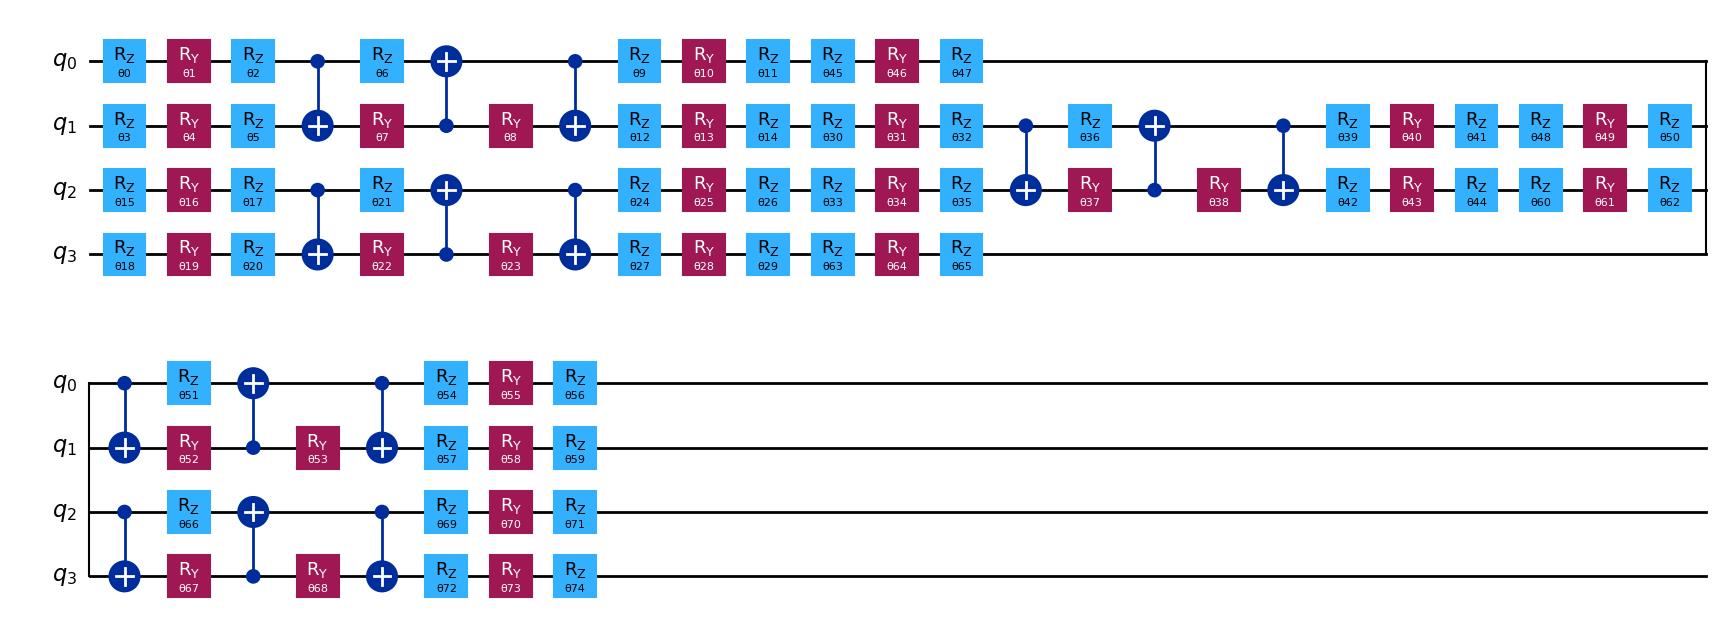

In [62]:
n_qubits = 4          # paper used 7; 4 keeps it fast to demo
depth = 3             # same depth as Fig. 5(a)
qc, params = brickwall_PQC(n_qubits=n_qubits, depth=depth)
print(f"PQC built: {n_qubits} qubits, depth {depth}, parameters: {len(params)}")


qc.draw('mpl')

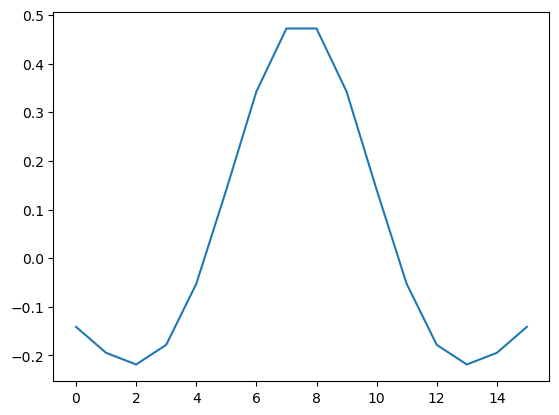

In [63]:
# target |g(x)⟩
g = ricker_target_state(n_qubits, sigma=0.8)

plt.plot(g)

In [64]:
# initial θ sampled uniformly from [0,1] as in the paper
rng = np.random.default_rng(7)
theta0 = rng.uniform(0.0, 1.0, size=len(params))

print(f"Randomized initial thetas: \n{theta0}")


# quick check of initial cost
initial_cost = cost(theta0)
print(f"Initial cost = {initial_cost:.6f}")

Randomized initial thetas: 
[0.62509547 0.8972138  0.77568569 0.22520719 0.30016628 0.87355345
 0.0052653  0.82122842 0.79706943 0.46793495 0.30303243 0.27842561
 0.25486959 0.44507631 0.50454826 0.55349735 0.99550028 0.79266192
 0.62217923 0.98896015 0.2153087  0.16021203 0.6125396  0.04394201
 0.03568028 0.51488882 0.46620603 0.91716777 0.62922625 0.51411765
 0.49687344 0.24751492 0.01179403 0.19240214 0.69203212 0.20060672
 0.36953631 0.00373424 0.83004773 0.15446108 0.2675993  0.88033215
 0.50979081 0.84715025 0.63971717 0.74177095 0.09149561 0.54114382
 0.50777224 0.87133938 0.36126406 0.59818407 0.05925164 0.3876318
 0.32303635 0.15019973 0.8163381  0.37944617 0.97874788 0.58999169
 0.60505625 0.63799658 0.67645024 0.15078802 0.44031347 0.23956396
 0.4024983  0.09670409 0.96782805 0.21500404 0.67176516 0.30042008
 0.87407703 0.66221474 0.13161582]
Initial cost = 0.901324


In [65]:
# build cost
cost = make_cost(qc, params, g)

# optimize with L-BFGS-B (increase maxiter toward 100_000 if you want to mirror the paper)
res = minimize(
    cost,
    theta0,
    method="L-BFGS-B",
    options=dict(maxiter=600, ftol=1e-9, gtol=1e-8, maxcor=20, eps=1e-8)
)

print("\nOptimization status:", res.message)
print("Iterations:", res.nit)
print("Final cost:", res.fun)



Optimization status: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Iterations: 182
Final cost: 2.4084531580870205e-05


In [66]:

theta_star = res.x
report(qc, params, theta_star, g)

# If you want the hardware-ready circuit with learned angles:
trained_qc = bind_params(qc, params, theta_star)

Final cost C(θ): 0.000024
Re(<g|ψ>): 0.999976,  Im(<g|ψ>): -0.000048
Fidelity |<g|ψ>|^2: 0.999952


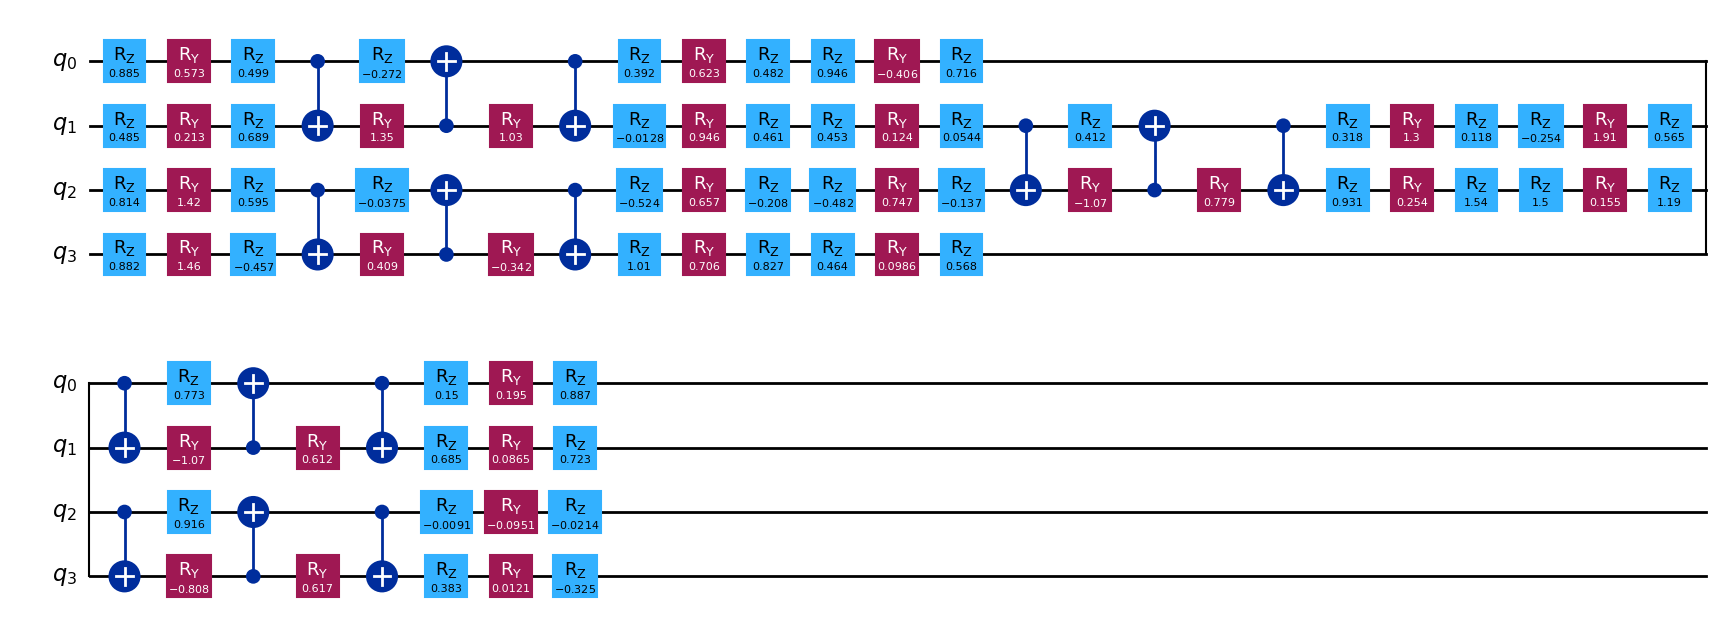

In [67]:
trained_qc.draw('mpl')   # visualize, or submit to your backend of choice

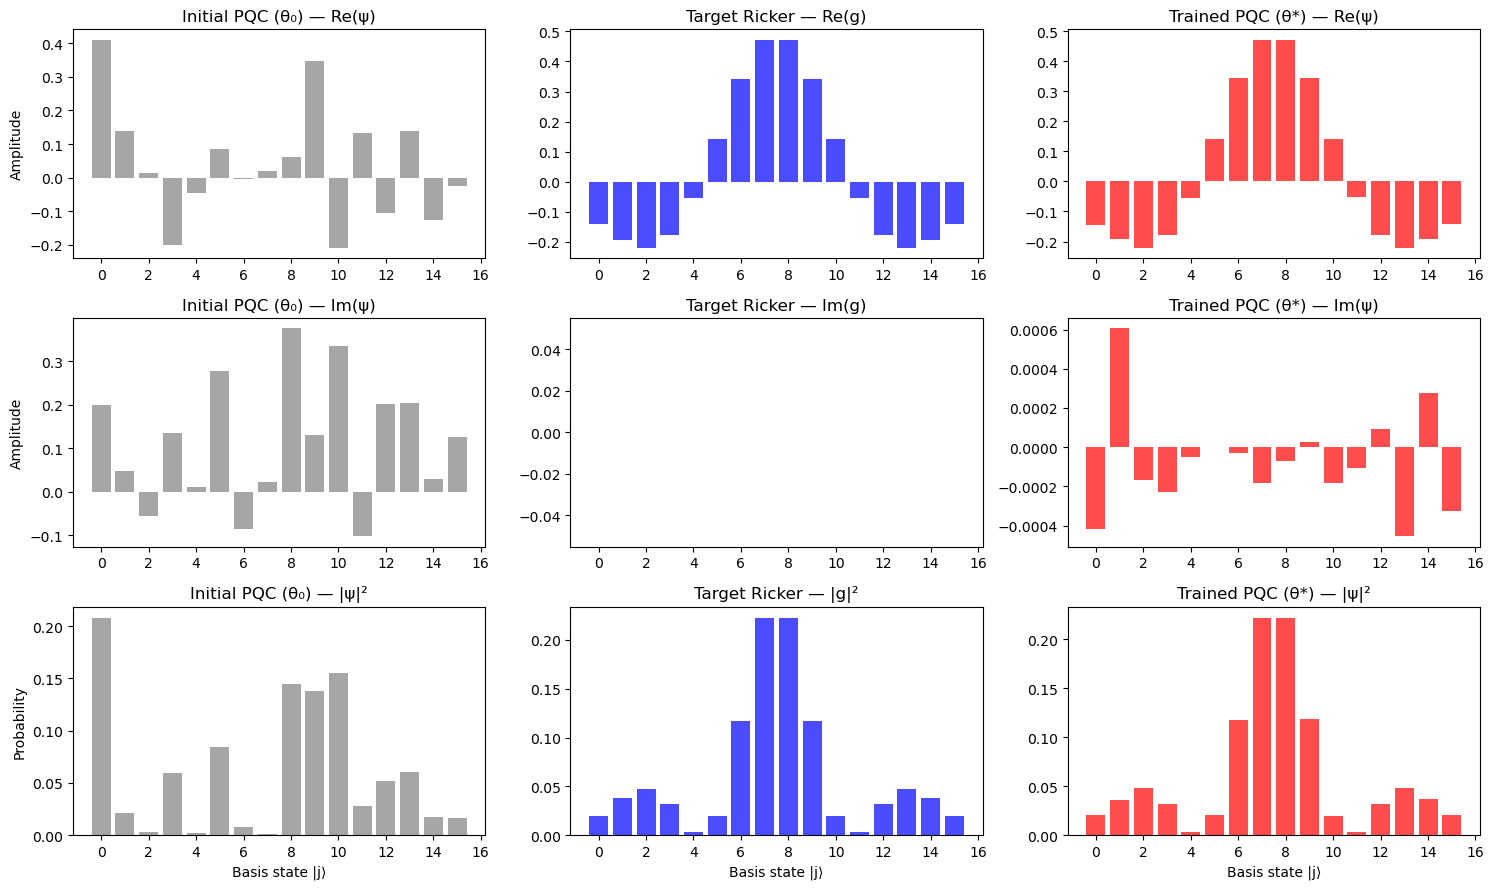

In [68]:
# ============================================================
#  Visualization: PQC at start (θ0), target, and trained (θ*)
# ============================================================

# --- 1. Compute statevector before training (θ0) ---
qc_init = qc.assign_parameters({p: float(theta0[i]) for i, p in enumerate(params)})
psi_init = Statevector.from_instruction(qc_init).data

# --- 2. Compute trained statevector (θ*) ---
qc_trained = qc.assign_parameters({p: float(theta_star[i]) for i, p in enumerate(params)})
psi_trained = Statevector.from_instruction(qc_trained).data

# --- 3. Target statevector (Ricker wavelet) ---
psi_target = g

# --- 4. Prepare plots ---
fig, axs = plt.subplots(3, 3, figsize=(15, 9))

# x-axis labels (basis state indices)
x = np.arange(len(psi_target))

# ===============================================
#  ROW 1 — Real part of amplitudes
# ===============================================
axs[0,0].bar(x, psi_init.real, color='gray', alpha=0.7)
axs[0,0].set_title("Initial PQC (θ₀) — Re(ψ)")
axs[0,0].set_ylabel("Amplitude")

axs[0,1].bar(x, psi_target.real, color='blue', alpha=0.7)
axs[0,1].set_title("Target Ricker — Re(g)")

axs[0,2].bar(x, psi_trained.real, color='red', alpha=0.7)
axs[0,2].set_title("Trained PQC (θ*) — Re(ψ)")

# ===============================================
#  ROW 2 — Imaginary part of amplitudes
# ===============================================
axs[1,0].bar(x, psi_init.imag, color='gray', alpha=0.7)
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_title("Initial PQC (θ₀) — Im(ψ)")

axs[1,1].bar(x, psi_target.imag, color='blue', alpha=0.7)
axs[1,1].set_title("Target Ricker — Im(g)")

axs[1,2].bar(x, psi_trained.imag, color='red', alpha=0.7)
axs[1,2].set_title("Trained PQC (θ*) — Im(ψ)")

# ===============================================
#  ROW 3 — Measurement probabilities |ψ|²
# ===============================================
axs[2,0].bar(x, np.abs(psi_init)**2, color='gray', alpha=0.7)
axs[2,0].set_ylabel("Probability")
axs[2,0].set_xlabel("Basis state |j⟩")
axs[2,0].set_title("Initial PQC (θ₀) — |ψ|²")

axs[2,1].bar(x, np.abs(psi_target)**2, color='blue', alpha=0.7)
axs[2,1].set_xlabel("Basis state |j⟩")
axs[2,1].set_title("Target Ricker — |g|²")

axs[2,2].bar(x, np.abs(psi_trained)**2, color='red', alpha=0.7)
axs[2,2].set_xlabel("Basis state |j⟩")
axs[2,2].set_title("Trained PQC (θ*) — |ψ|²")

# Tight layout for readability
plt.tight_layout()
plt.show()


# Alternative process: Quantum Signal Processing (QSP)

The downside of using optimization for finding the thetas are increased steps, time, number of variables (theats) that will making the traning takes longer 

Also it is mentioned and persented in the paper increased infidelity with the number of qubits while keeping the optimizer parameters the same 